# CLIP embeddings to improve multimodal RAG with GPT-4 Vision


Multimodal RAG supercharges the traditional text-based RAG with other modalities to provide further useful context to an LLM to help answer questions. Other modalities may hold information required to answer questions which do not exist within the text or they provide useful grounding for the textual data to improve the LLM's understanding.

Building on work done in the [clothing matchmaker cookbook](https://cookbook.openai.com/examples/how_to_combine_gpt4v_with_rag_outfit_assistant), instead of using GPT-4V to caption an image and perform RAG on the caption, we instead embed the image directly as use that as the basis of our similarity search. The reason for this is in certain situations, there is information loss in converting an image to text as the text cannot fully capture the richness of the image. Therefore this direct image embedding may improve the most crucial part of RAG, the retrieval.

An additional benefit of using CLIP-based embeddings is that we are also able to finetune CLIP to an enterprises proprietary data or to update it with images it has not yet seen.

The application area we will use to bring this technique to life is performing RAG over user inputted images of technology and searching our enterprise knowledge base for a matching image to provide helpful information for the end user.

### Installations and imports
Install the relevant packages

In [ ]:
#installations
!pip install clip
!pip install torch
!pip install pillow
!pip install faiss-cpu
!pip install numpy
!pip install git+https://github.com/openai/CLIP.git
!pip install openai

Import all the needed packages


In [44]:
#imports
import json
from PIL import Image
from tqdm import tqdm
import torch
from openai import OpenAI
import torch.nn as nn
from torch.utils.data import DataLoader
import clip
import json
import matplotlib.pyplot as plt
import os
import base64
import numpy as np
import pickle
from typing import List, Union, Tuple
import faiss

Load the CLIP model

In [45]:
#load model on device
device = "cpu"
model, preprocess = clip.load("ViT-B/32",device=device)

Next we will create our image embeddings knowledge base from a directory of images. This will be the knowledge base of technology that we search through to provide information to the user for an image they upload.

We pass in the directory in which we store our images (as JPEGs) and loop through each to create our embeddings.

We also have a description.json. This has an entry for every single image in our knowledge base. It has two keys: 'image_path' and 'description'. It maps each image to a useful description of this image to aid in answering the question.

In [46]:
#get all image paths in a directory
def get_image_paths(directory: str, number: int = None) -> List[str]:
    image_paths = []
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith('.jpeg'):
            image_paths.append(os.path.join(directory, filename))
            if number is not None and count == number:
                return [image_paths[-1]]
            count += 1
    return image_paths
direc = 'image_database/'
image_paths = get_image_paths(direc)
def get_features_from_image_path(image_paths):
  images = [preprocess(Image.open(image_path).convert("RGB")) for image_path in image_paths]
  image_input = torch.tensor(np.stack(images))
  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
  return image_features
image_features = get_features_from_image_path(image_paths)
index = faiss.IndexFlatIP(image_features.shape[1])
index.add(image_features)


data = []
with open('description.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))
def find_entry(data, key, value):
    for entry in data:
        if entry.get(key) == value:
            return entry
    return None

Let us display an example image, this will be the user uploaded image. This is a piece of tech that was unveiled at the 2024 CES. It is the DELTA Pro Ultra Whole House Battery Generator.

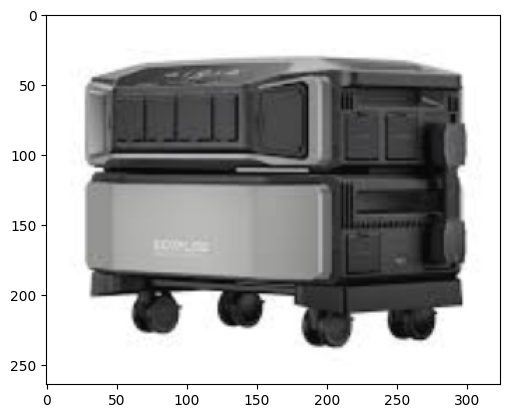

In [47]:
image_path = 'train1.jpeg'
im = Image.open(image_path)
plt.imshow(im)
plt.show()

Now let's have a look at what GPT-4 Vision which wouldn't have seen this technology before will label it as. As we can see, it tries it's best from the information it's been trained on but it makes a mistake due to it not having seen anything similar in its training data and because it is an ambiguous image making it difficult to extrapolate and deduce.

In [48]:
def encode_image(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return encoded_image.decode('utf-8')

def image_query(query, image_path):
    response = client.chat.completions.create(
        model='gpt-4-vision-preview',
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": query,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encode_image(image_path)}",
                },
                }
            ],
            }
        ],
        max_tokens=300,
    )
    # Extract relevant features from the response
    return response.choices[0].message.content
image_query('Write a short label of what is show in this image?', 'train1.jpeg')

'Autonomous Delivery Robot'

Now let's perform similarity search to find the two most similar images in our knowledge base

In [49]:
image_search_embedding = get_features_from_image_path([image_path])
distances, indices = index.search(image_search_embedding.reshape(1, -1), 2) #2 signifies the number of topmost similar images to bring back
distances = distances[0]
indices = indices[0]
indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1], reverse=True)

And let's see what it brought back (we display these in order of similarity):

2


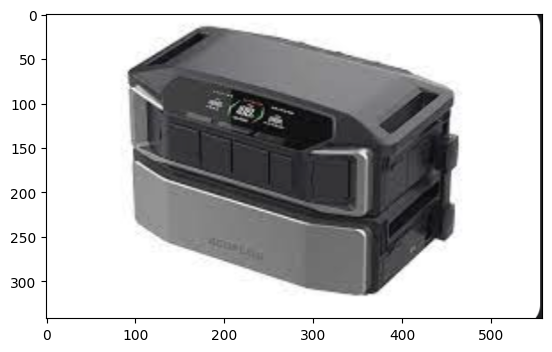

11


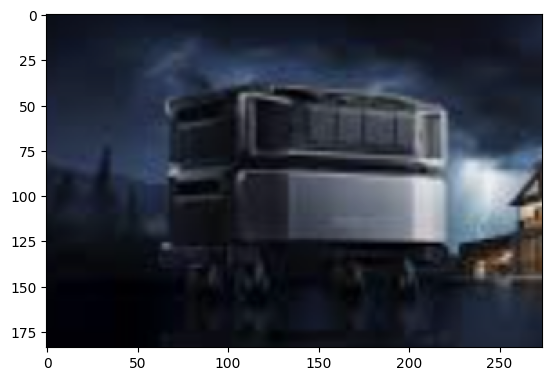

In [50]:
#display similar images
for idx, distance in indices_distances:
    print(idx)
    path = get_image_paths(direc, idx)[0]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()

Now for our most similar image, I want to pass it and the description of it to gpt-v with a user query so they can inquire about the technology that they may have bought.

In [51]:
similar_path = get_image_paths(direc, indices_distances[0][0])[0]
element = find_entry(data, 'image_path', similar_path)

user_query = 'What is the capacity of this item?'
prompt = f"""
Below is a user query, I want you to answer the query using the description and image provided.

user query:
{user_query}

description:
{element['description']}
"""
image_query(prompt, similar_path)

'The portable home battery shown in the image, the DELTA Pro, has a capacity of 3.6kWh which can be expanded up to 25kWh with additional batteries. By integrating the DELTA Pro with your home circuits via the Smart Home Panel, you can achieve greater capacities: connecting one add-on battery doubles the total capacity to 7200Wh, and connecting two add-on batteries brings the total up to 10.8kWh for off-grid use.'

You have now completed the CLIP embeddings to improve multimodal RAG with GPT-4 Vision tutorial. The applications of this spread across many different application domains and this is easily improved to further enhance the technique. For example you may finetune CLIP, you may improve the retrieval process just like in RAG and you can prompt engineer GPT-V.
